## **04 - Decision Tree**

## **1. Instalaciones y Importaciones**

In [212]:
!pip install missingpy MissForest

In [284]:
import pandas as pd
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    confusion_matrix
)
from joblib import load
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from joblib import dump

from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance
import shap
import lightgbm as lgb
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier



## **2.Subir el Dataset**

In [214]:
from google.colab import files
uploaded = files.upload()

Saving internal-link.csv to internal-link (2).csv


## **3. Abrir el Dataset**

In [215]:
df = pd.read_csv('internal-link.csv')
pd.set_option('display.max_columns', None)
df.head(20)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [216]:
df.shape

(768, 9)

## **4.Descripción de las Variables:**

In [217]:
for col in df.columns:
    print(f"\nColumna: {col}")

    # Conteos absolutos
    conteos = df[col].value_counts(dropna=False)

    # Porcentajes
    porcentajes = df[col].value_counts(normalize=True, dropna=False) * 100

    # Combinar en un solo DataFrame
    resumen = pd.DataFrame({
        'Conteo': conteos,
        'Porcentaje (%)': porcentajes.round(2)
    })

    print(resumen)


Columna: Pregnancies
             Conteo  Porcentaje (%)
Pregnancies                        
1               135           17.58
0               111           14.45
2               103           13.41
3                75            9.77
4                68            8.85
5                57            7.42
6                50            6.51
7                45            5.86
8                38            4.95
9                28            3.65
10               24            3.12
11               11            1.43
13               10            1.30
12                9            1.17
14                2            0.26
17                1            0.13
15                1            0.13

Columna: Glucose
         Conteo  Porcentaje (%)
Glucose                        
99           17            2.21
100          17            2.21
111          14            1.82
125          14            1.82
129          14            1.82
...         ...             ...
56            1     

## **5. Cribado Manual**

## 5.1 Identificar columnas con columnas constantes.   No tenemos columnas con valores constantes

In [218]:
unicos = df.nunique()
df[unicos[unicos==1].index]
df[unicos[unicos==1].index].head(5)

""
0
1
2
3
4


## 5.2 Eliminamos filas y columnas duplicadas. No Eliminamos ninguna.


In [219]:
df.duplicated().sum()

np.int64(0)

In [220]:
df[df.duplicated(keep=False)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [221]:
df.T.duplicated().sum()

np.int64(0)

In [222]:
df.T.duplicated(keep=False)

,0
Pregnancies,False
Glucose,False
BloodPressure,False
SkinThickness,False
Insulin,False
BMI,False
DiabetesPedigreeFunction,False
Age,False
Outcome,False


## 5.3. Eliminar columnas redundantes

## 5.4 Eliminar columnas Data leakage

In [223]:
##df.drop(['price'], axis=1, inplace=True)

## **6.Analizar Valores sin sentido** Glucosa hay valores de 30 a 600. Presión Arterial de 30 a 200. SkinThickness hay valores de cero a 99. Insulin de 0 a 300. BMI de 10 a 60. y de DiabetesPedigreeFunction de 0 a 2.5

In [224]:
df_clean = df.copy()
df_clean.loc[(df_clean["Glucose"] < 30) | (df_clean["Glucose"] > 600), "Glucose"] = np.nan
df_clean.loc[(df_clean["BloodPressure"] < 30) | (df_clean["BloodPressure"] > 200), "BloodPressure"] = np.nan
df_clean.loc[(df_clean["SkinThickness"] <= 0) | (df_clean["SkinThickness"] > 99), "SkinThickness"] = np.nan
df_clean.loc[(df_clean["Insulin"] <= 0) | (df_clean["Insulin"] > 300), "Insulin"] = np.nan
df_clean.loc[df_clean["BMI"] < 10, "BMI"] = np.nan
df_clean.loc[(df_clean["DiabetesPedigreeFunction"] < 0) | (df_clean["DiabetesPedigreeFunction"] > 2.5), "DiabetesPedigreeFunction"] = np.nan

df_clean.head(20)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
5,5,116.0,74.0,NaN,NaN,25.6,0.201,30,0
6,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
7,10,115.0,NaN,NaN,NaN,35.3,0.134,29,0
8,2,197.0,70.0,45.0,NaN,30.5,0.158,53,1
9,8,125.0,96.0,NaN,NaN,NaN,0.232,54,1


## **7. Valores faltantes por columna** Tiene que ser mayor a 40 % Para poder eliminarlas. Eliminamos la Insulina.

In [225]:
df_clean.shape

(768, 9)

In [226]:
faltantes = df_clean.isna().mean()*100
faltantes[faltantes>0]

,0
Glucose,0.651042
BloodPressure,4.687500
SkinThickness,29.557292
Insulin,53.515625
BMI,1.432292


In [227]:
df_clean = df_clean.drop(columns=["Insulin"])

## **8. Valores faltantes por filas. Se mira cuantas valores faltantes hay en los clientes.** No eliminamos ninguna

In [228]:
df_clean.isnull().any(axis=1).sum()

np.int64(237)

In [229]:
n = 2
df_clean[df_clean.isnull().sum(axis=1) == n]

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
7,10,115.0,NaN,NaN,35.3,0.134,29,0
9,8,125.0,96.0,NaN,NaN,0.232,54,1
15,7,100.0,NaN,NaN,30.0,0.484,32,1
78,0,131.0,NaN,NaN,43.2,0.270,26,1
193,11,135.0,NaN,NaN,52.3,0.578,40,1
222,7,119.0,NaN,NaN,25.2,0.209,37,0
261,3,141.0,NaN,NaN,30.0,0.761,27,1
266,0,138.0,NaN,NaN,36.3,0.933,25,1
269,2,146.0,NaN,NaN,27.5,0.240,28,1
300,0,167.0,NaN,NaN,32.3,0.839,30,1


In [230]:
n = 3
df_clean[df_clean.isnull().sum(axis=1) == n]

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
49,7,105.0,NaN,NaN,NaN,0.305,24,0
60,2,84.0,NaN,NaN,NaN,0.304,21,0
81,2,74.0,NaN,NaN,NaN,0.102,22,0
426,0,94.0,NaN,NaN,NaN,0.256,25,0
494,3,80.0,NaN,NaN,NaN,0.174,22,0
522,6,114.0,NaN,NaN,NaN,0.189,26,0
706,10,115.0,NaN,NaN,NaN,0.261,30,1


<Axes: >

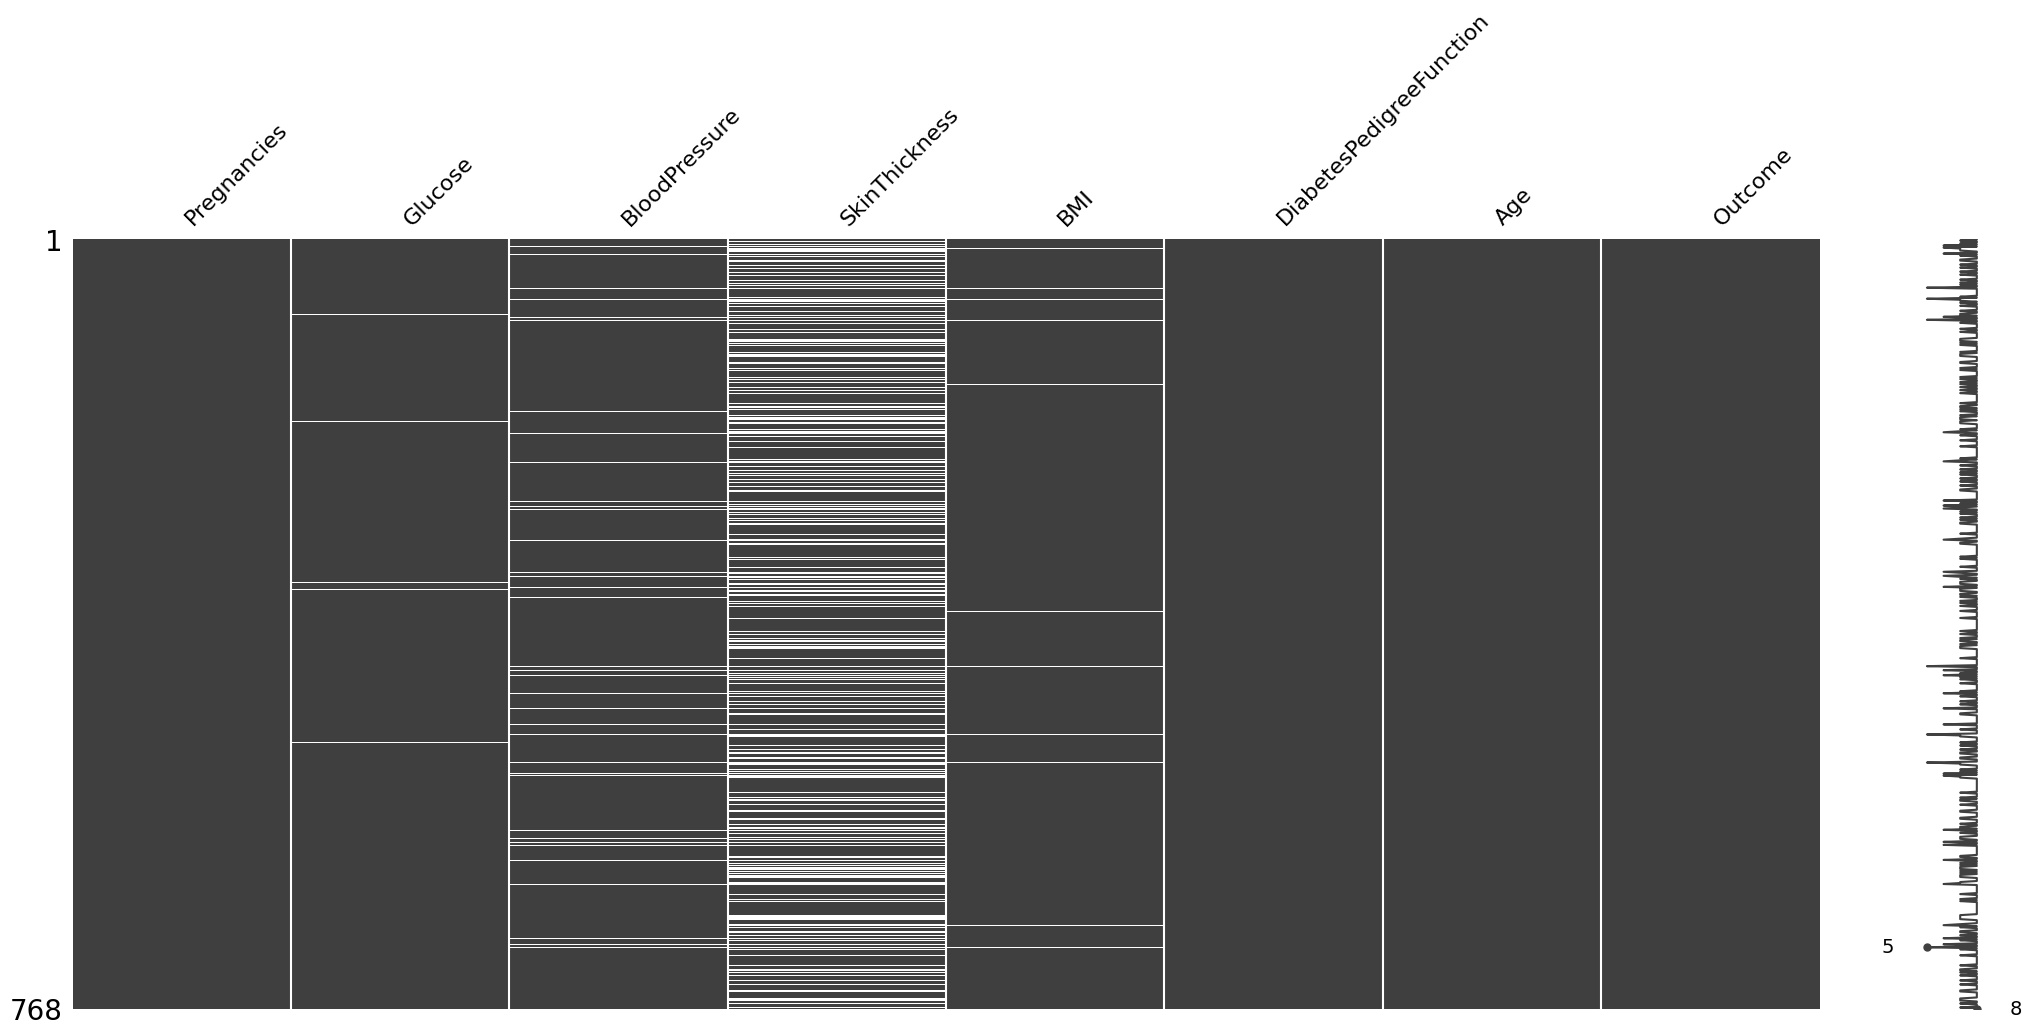

In [231]:
msno.matrix(df_clean)

In [232]:
df.shape

(768, 9)

## **9. Train test split**

In [233]:
X = df.drop('Outcome',axis=1)
y = df['Outcome']

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **10. Imputar**

In [235]:
X_train[['Glucose',	'BloodPressure',	'SkinThickness', 'BMI']]

,Glucose,BloodPressure,SkinThickness,BMI
60,84,0,0,0.0
618,112,82,24,28.2
346,139,46,19,28.7
294,161,50,0,21.9
231,134,80,37,46.2
...,...,...,...,...
71,139,64,35,28.6
106,96,122,0,22.4
270,101,86,37,45.6
435,141,0,0,42.4


In [236]:
X_train['Glucose'].value_counts(normalize=True)*100

,proportion
Glucose,
99,2.605863
100,2.442997
125,2.117264
108,1.954397
106,1.954397
...,...
198,0.162866
178,0.162866
167,0.162866


In [237]:
X_train['SkinThickness'].value_counts(normalize=True)*100

,proportion
SkinThickness,
0,28.664495
30,3.908795
32,3.745928
23,3.420195
27,2.768730
33,2.768730
19,2.768730
18,2.605863
39,2.605863


In [238]:
X_train['BMI'].value_counts(normalize=True)*100

,proportion
BMI,
32.0,1.954397
31.6,1.791531
31.2,1.628664
30.1,1.465798
32.4,1.465798
...,...
49.6,0.162866
22.3,0.162866
33.5,0.162866


In [239]:
cols_imputar = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']
X_train_imp = X_train.copy()
imputer = KNNImputer(n_neighbors=5)  # puedes cambiar el número de vecinos
X_train_imp[cols_imputar] = imputer.fit_transform(X_train_imp[cols_imputar])

In [240]:
X_test_imp = X_test.copy()
X_test_imp[cols_imputar] = imputer.transform(X_test_imp[cols_imputar])

## **11. Chequear los OUTLIERS**

In [241]:
X_train_imp.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,614.0,3.742671,3.313264,0.000,1.0000,3.0000,6.00000,17.00
Glucose,614.0,120.855049,32.035057,0.000,100.0000,117.0000,139.00000,199.00
BloodPressure,614.0,69.415309,18.512599,0.000,64.0000,72.0000,80.00000,122.00
SkinThickness,614.0,20.399023,15.433974,0.000,0.0000,23.0000,32.00000,63.00
Insulin,614.0,81.438111,116.234835,0.000,0.0000,42.5000,129.75000,846.00
BMI,614.0,31.983388,7.740625,0.000,27.1000,32.0000,36.37500,67.10
DiabetesPedigreeFunction,614.0,0.469168,0.336847,0.078,0.2415,0.3725,0.61375,2.42
Age,614.0,32.907166,11.503437,21.000,24.0000,29.0000,40.00000,81.00


In [242]:
iso = IsolationForest(random_state=123)
df_num = X_train_imp.copy()
df_num['outlier_flag'] = iso.fit_predict(X_train_imp)

In [243]:
df_num['outlier_flag'].value_counts()

,count
outlier_flag,
1,544
-1,70


## **12. Selección de Características**

## Método 1: Feature importance de RF

In [244]:
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [245]:
# Importancia de características
importances = model.feature_importances_ / model.feature_importances_.sum() * 100

# Convertir a DataFrame
df_dt_imp = pd.DataFrame({
    'feature': X_train_imp.columns,
    'dt_importance': importances
}).sort_values(by='dt_importance', ascending=False)

# Calculamos la importancia acumulada
df_dt_imp['dt_importance_acum'] = df_dt_imp['dt_importance'].cumsum()

In [246]:
df_dt_imp

,feature,dt_importance,dt_importance_acum
1,Glucose,31.422474,31.422474
5,BMI,17.070035,48.492509
2,BloodPressure,14.767907,63.260416
7,Age,9.921536,73.181952
6,DiabetesPedigreeFunction,8.328237,81.510190
4,Insulin,6.625279,88.135469
3,SkinThickness,6.116378,94.251847
0,Pregnancies,5.748153,100.000000


Método 2: Permutation/Shuffle importance

In [247]:
# Para esta técnica y la de shap se necesita conjunto de validación
X_train1, X_val, y_train1, y_val = train_test_split(
    X_train_imp, y_train, test_size=0.2, random_state=42
)

# Ajustar modelo Decision Tree (regresión)
model_dt = DecisionTreeRegressor(random_state=42)
model_dt.fit(X_train1, y_train1)

DecisionTreeRegressor(random_state=42)

In [248]:
# Realizamos 10 permutaciones por cada característica
perm = permutation_importance(
    model_dt,
    X_val,
    y_val,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='neg_mean_absolute_percentage_error'
)


In [249]:
df_perm_imp = pd.DataFrame({
    'feature': X_train_imp.columns,
    'perm_imp': perm.importances_mean * 100
}).sort_values('perm_imp', ascending=False)

df_perm_imp

,feature,perm_imp
1,Glucose,4.503600e+16
0,Pregnancies,3.148858e+16
7,Age,2.636253e+16
4,Insulin,9.153658e+15
5,BMI,8.055219e+15
2,BloodPressure,2.929170e+15
3,SkinThickness,1.098439e+15
6,DiabetesPedigreeFunction,-5.492195e+15


Método 3: SHAP

In [250]:
# Ajustamos el modelo
model_dt = DecisionTreeRegressor(random_state=42)
model_dt.fit(X_train1, y_train1)

explainer = shap.TreeExplainer(model_dt)
shap_vals = explainer.shap_values(X_val)

In [251]:
imp_shap = np.abs(shap_vals).mean(axis=0)
imp_shap_pct = imp_shap / imp_shap.sum() * 100

df_shap_imp = pd.DataFrame({
    "feature": X_val.columns,
    "shap_imp": imp_shap_pct
}).sort_values("shap_imp", ascending=False)

In [252]:
# --- SHAP Summary Bar Plot ---
df_shap_imp

,feature,shap_imp
1,Glucose,29.996330
7,Age,18.193358
5,BMI,13.940988
6,DiabetesPedigreeFunction,13.744976
2,BloodPressure,10.627333
0,Pregnancies,6.618686
3,SkinThickness,3.934811
4,Insulin,2.943518


Unión 3 métodos

In [253]:
df_importances = (
    df_dt_imp
    .merge(df_perm_imp, on='feature', how='outer')
    .merge(df_shap_imp, on='feature', how='outer')
).sort_values('dt_importance', ascending=False)

df_importances

,feature,dt_importance,dt_importance_acum,perm_imp,shap_imp
4,Glucose,31.422474,31.422474,4.503600e+16,29.996330
1,BMI,17.070035,48.492509,8.055219e+15,13.940988
2,BloodPressure,14.767907,63.260416,2.929170e+15,10.627333
0,Age,9.921536,73.181952,2.636253e+16,18.193358
3,DiabetesPedigreeFunction,8.328237,81.510190,-5.492195e+15,13.744976
5,Insulin,6.625279,88.135469,9.153658e+15,2.943518
7,SkinThickness,6.116378,94.251847,1.098439e+15,3.934811
6,Pregnancies,5.748153,100.000000,3.148858e+16,6.618686


In [254]:
df_filt = df_importances[
    (df_importances['dt_importance'] >= 1) &
    (df_importances['perm_imp'] >= 1) &
    (df_importances['shap_imp'] >= 1)
]

df_filt

,feature,dt_importance,dt_importance_acum,perm_imp,shap_imp
4,Glucose,31.422474,31.422474,4.503600e+16,29.996330
1,BMI,17.070035,48.492509,8.055219e+15,13.940988
2,BloodPressure,14.767907,63.260416,2.929170e+15,10.627333
0,Age,9.921536,73.181952,2.636253e+16,18.193358
5,Insulin,6.625279,88.135469,9.153658e+15,2.943518
7,SkinThickness,6.116378,94.251847,1.098439e+15,3.934811
6,Pregnancies,5.748153,100.000000,3.148858e+16,6.618686


##**13. Medir Correlación de Variables**

In [255]:
features = df_filt['feature']
features

,feature
4,Glucose
1,BMI
2,BloodPressure
0,Age
5,Insulin
7,SkinThickness
6,Pregnancies


In [256]:
from statsmodels.tools.tools import add_constant

X_vif = add_constant(X_train[features])

vif = pd.Series([variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],index=X_vif.columns)
vif = vif.drop("const")
vif

,0
Glucose,1.321393
BMI,1.274509
BloodPressure,1.162064
Age,1.619088
Insulin,1.449551
SkinThickness,1.514766
Pregnancies,1.448827


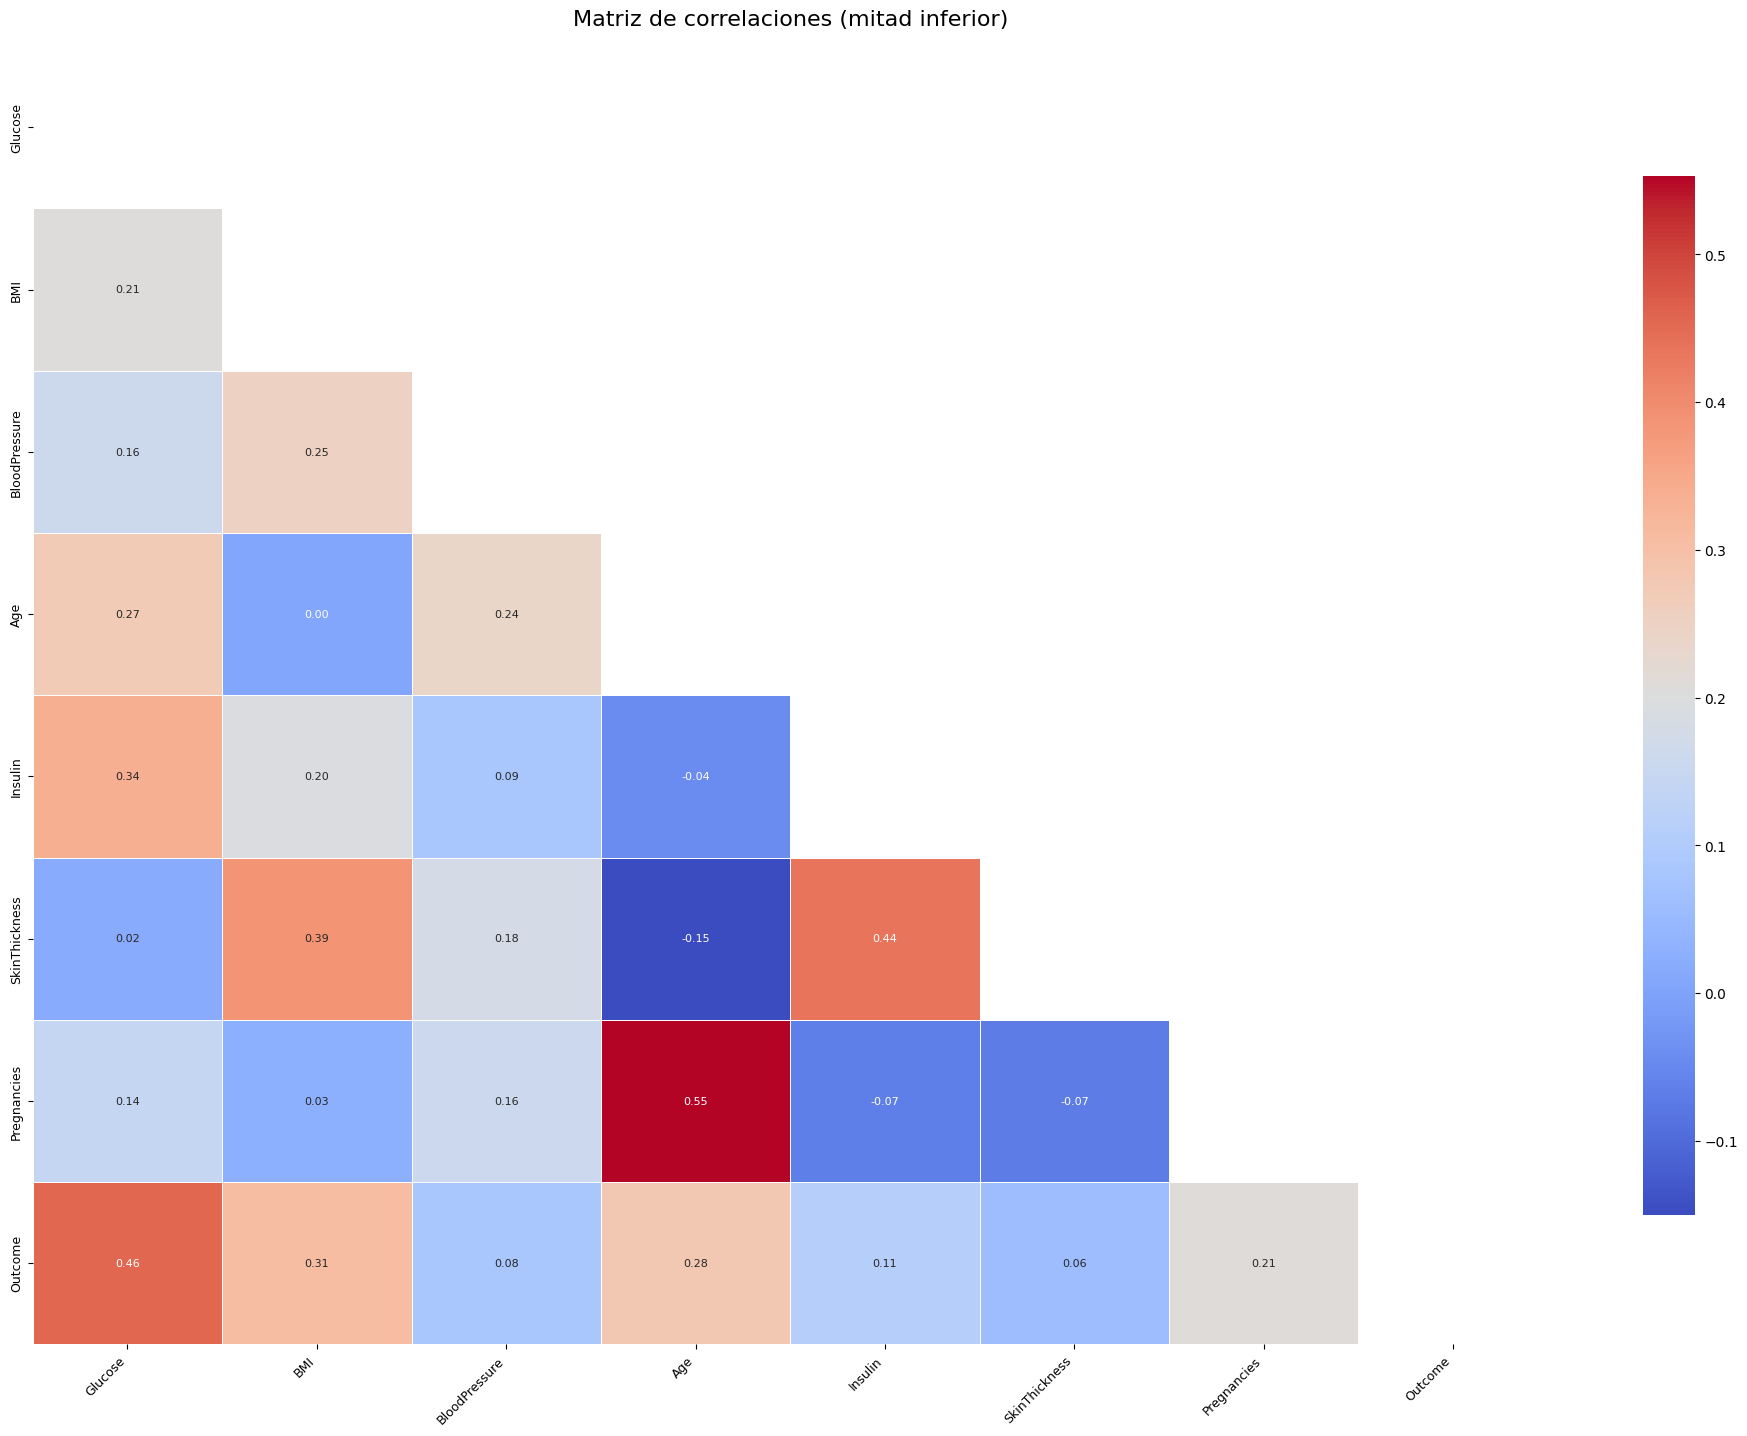

In [257]:
X_copy = X_train[features].copy()
X_copy['Outcome'] = y_train
corr = X_copy.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20, 15))
sns.heatmap(
    corr, mask=mask, cmap='coolwarm',
    annot=True, fmt=".2f", linewidths=.5,
    cbar_kws={"shrink": .8},
    annot_kws={"size": 8}
)
plt.title("Matriz de correlaciones (mitad inferior)", fontsize=16, pad=15)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout(pad=3.0)
plt.show()

## **14.Cross Validation**

In [258]:
# Versión 1: Realizar cross_validation con todas las características que son candidatas
cv_results_dt = cross_val_score(
    DecisionTreeRegressor(random_state=42),
    X_train[features],
    y_train,
    cv=3,
    scoring='neg_mean_absolute_percentage_error'
)

print(cv_results_dt)
print("MAPE medio:", -cv_results_dt.mean())

[-6.37094581e+14 -7.68907253e+14 -6.84370532e+14]
MAPE medio: 696790788832207.1


In [259]:
# Versión 2: Realizar cross_validation con  las características que son candidatas sin las correlacionadas
cv_results2 = cross_val_score(DecisionTreeRegressor(random_state=42), X_train[features].drop(['Pregnancies'],axis=1), y_train, cv=3, scoring='neg_mean_absolute_percentage_error')

In [260]:
cv_results2.mean()*-1

np.float64(608807984060287.1)


## **15. Modelado**

In [261]:
# Selecciona la caracteristicas con las que hemos determinado que vamos a proseguir el análisis
X_train_sel = X_train[features]
X_test_sel = X_test[features]

In [262]:
X_train_sel.describe().T

,count,mean,std,min,25%,50%,75%,max
Glucose,614.0,120.855049,32.035057,0.0,100.0,117.0,139.000,199.0
BMI,614.0,31.983388,7.740625,0.0,27.1,32.0,36.375,67.1
BloodPressure,614.0,69.415309,18.512599,0.0,64.0,72.0,80.000,122.0
Age,614.0,32.907166,11.503437,21.0,24.0,29.0,40.000,81.0
Insulin,614.0,81.438111,116.234835,0.0,0.0,42.5,129.750,846.0
SkinThickness,614.0,20.399023,15.433974,0.0,0.0,23.0,32.000,63.0
Pregnancies,614.0,3.742671,3.313264,0.0,1.0,3.0,6.000,17.0


## **16. Gráfico de Variables**

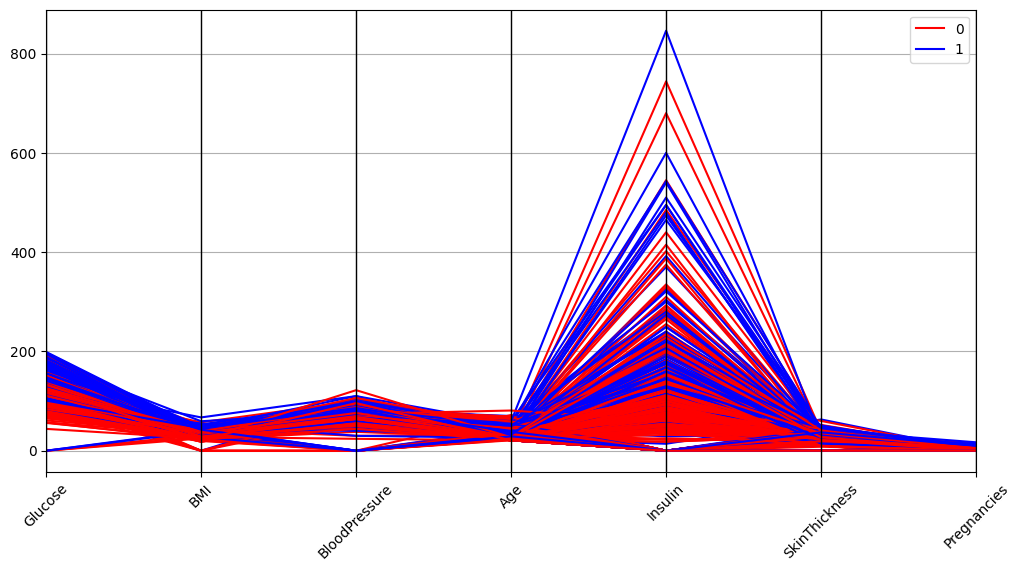

In [263]:

df_plot = X_train_sel.copy()
df_plot["Outcome"] = y_train.values
plt.figure(figsize=(12, 6))
pd.plotting.parallel_coordinates(df_plot, 'Outcome', color=['red', 'blue'])
plt.xticks(rotation=45)
plt.show()


In [264]:
y_train.skew()

np.float64(0.6448502342244199)

In [265]:
y_train.describe()

,Outcome
count,614.000000
mean,0.346906
std,0.476373
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## **17. Hacer Logaritmo de la Variable Y**

In [266]:
scaler = StandardScaler()

df_plot_sc = pd.DataFrame(
    scaler.fit_transform(df_plot.drop(['Outcome'], axis=1)),
    columns=df_plot.columns[:-1],
    index=df_plot.index
)

df_plot_sc['Outcome'] = df_plot['Outcome']

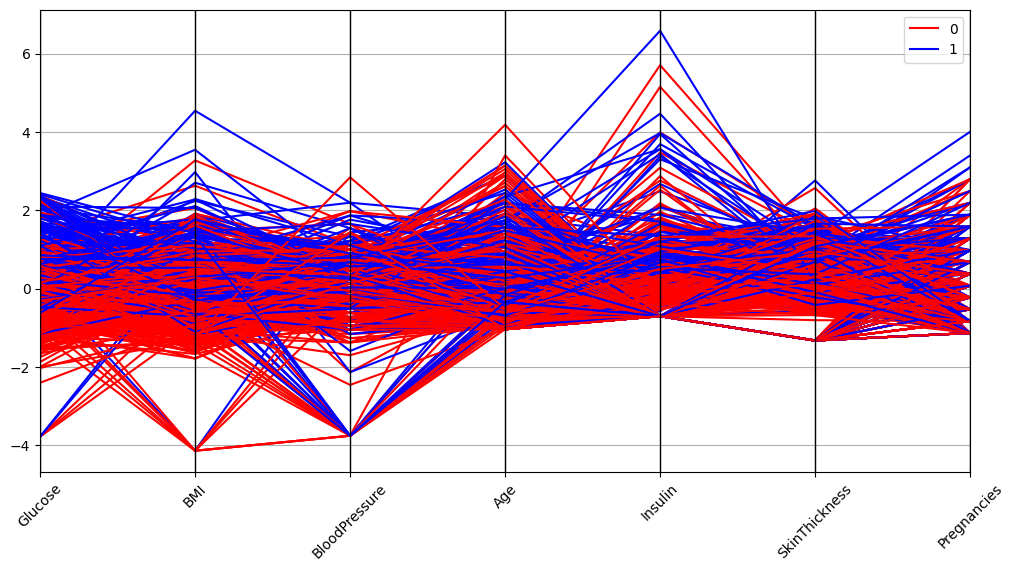

In [267]:
plt.figure(figsize=(12, 6))
pd.plotting.parallel_coordinates(
    df_plot_sc,
    'Outcome',
    color=['red', 'blue']
)
plt.xticks(rotation=45)
plt.show()

## **18.Entrenamiento de las Variables**

In [268]:


# Árbol simple
simple_tree = DecisionTreeClassifier(
    max_depth=3,
    max_features=X_train_sel.shape[1] // 2,
    min_samples_leaf=20,
    random_state=42
)

simple_tree.fit(X_train_sel, y_train)

# Árbol complejo
complex_tree = DecisionTreeClassifier(
    max_depth=100,
    min_samples_leaf=1,
    random_state=42
)

complex_tree.fit(X_train_sel, y_train)

DecisionTreeClassifier(max_depth=100, random_state=42)

## **19. Evaluación correcta y Gráfico**

In [269]:
# Árbol complejo
train_pred_complex = complex_tree.predict(X_train_sel)
test_pred_complex = complex_tree.predict(X_test_sel)

# Árbol simple
train_pred_simple = simple_tree.predict(X_train_sel)
test_pred_simple = simple_tree.predict(X_test_sel)

In [270]:
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [271]:
metrics_complex = get_metrics(y_train, y_test, train_pred_complex, test_pred_complex)
metrics_complex

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Test,0.701299,0.581818,0.674747,0.581818,0.581818,0.767677
Diferencia,0.298701,0.418182,0.325253,0.418182,0.418182,0.232323


In [272]:
metrics_simple = get_metrics(y_train, y_test, train_pred_simple, test_pred_simple)
metrics_simple

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.723127,0.639831,0.719797,0.583012,0.708920,0.730673
Test,0.636364,0.582090,0.652525,0.493671,0.709091,0.595960
Diferencia,0.086763,0.057741,0.067271,0.089341,-0.000171,0.134714


In [273]:
# Matriz de confusión
cm = confusion_matrix(y_test, test_pred_simple)
cm

array([[59, 40],
       [16, 39]])

In [274]:
text_representation = export_text(simple_tree, feature_names=list(X_train_sel.columns))
print(text_representation)

|--- Age <= 28.50
|   |--- SkinThickness <= 31.50
|   |   |--- BMI <= 31.10
|   |   |   |--- class: 0
|   |   |--- BMI >  31.10
|   |   |   |--- class: 0
|   |--- SkinThickness >  31.50
|   |   |--- BMI <= 40.95
|   |   |   |--- class: 0
|   |   |--- BMI >  40.95
|   |   |   |--- class: 1
|--- Age >  28.50
|   |--- BMI <= 27.85
|   |   |--- Age <= 42.50
|   |   |   |--- class: 0
|   |   |--- Age >  42.50
|   |   |   |--- class: 0
|   |--- BMI >  27.85
|   |   |--- Insulin <= 142.00
|   |   |   |--- class: 1
|   |   |--- Insulin >  142.00
|   |   |   |--- class: 1



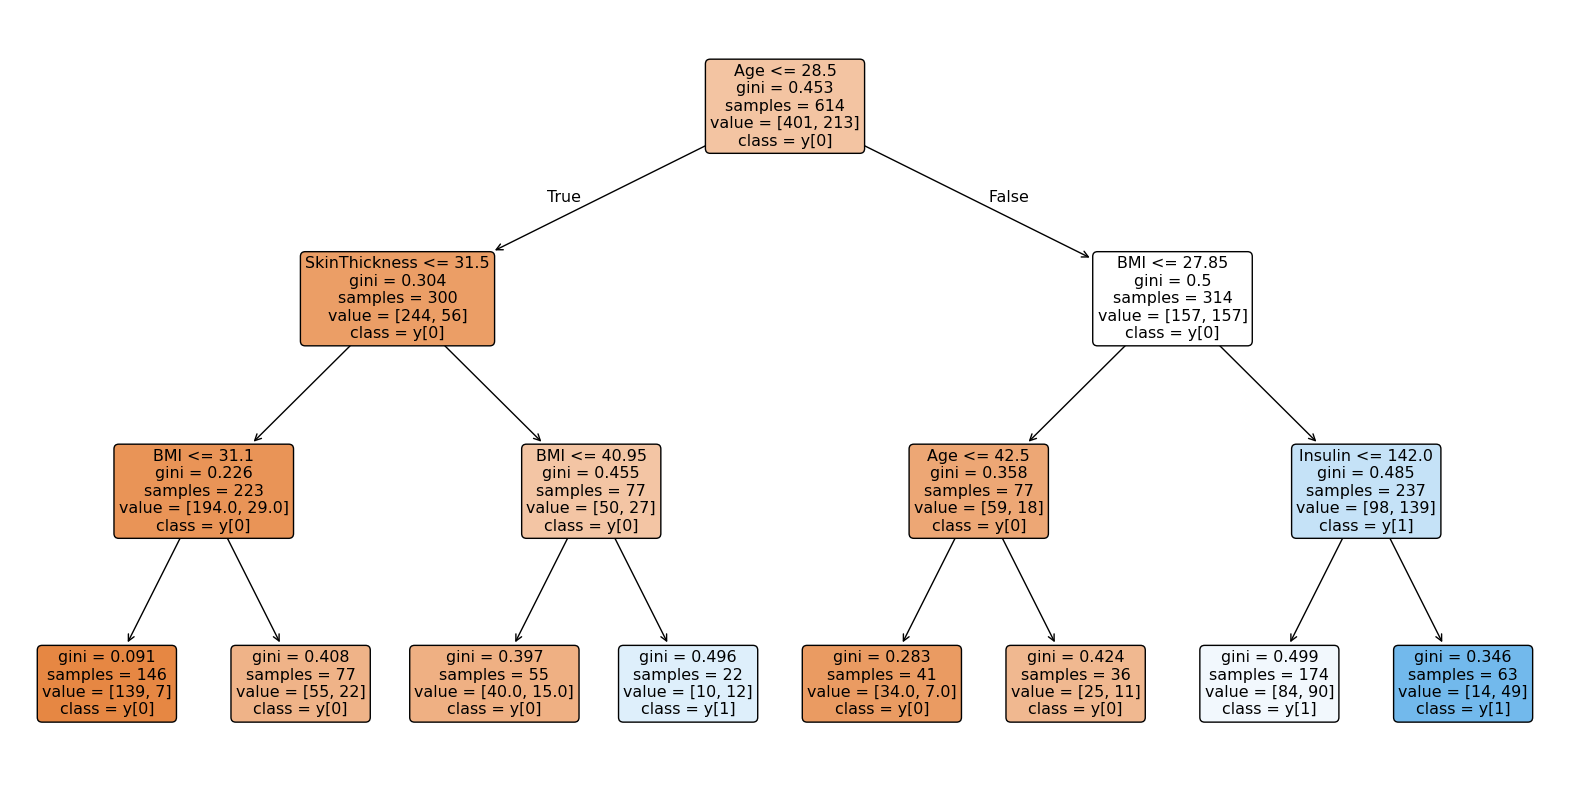

In [275]:

plt.figure(figsize=(20,10))
plot_tree(
    simple_tree,
    feature_names=X_train_sel.columns,
    class_names=True,      # o ['No', 'Sí'] si es clasificación binaria
    filled=True,
    rounded=True
)
plt.show()

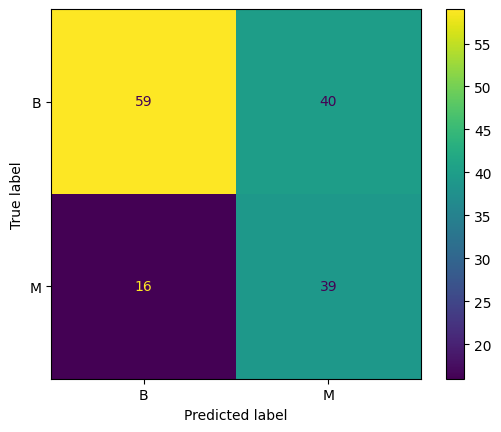

In [276]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['B', 'M'])
disp.plot()

## **20. Graficar las Métricas**

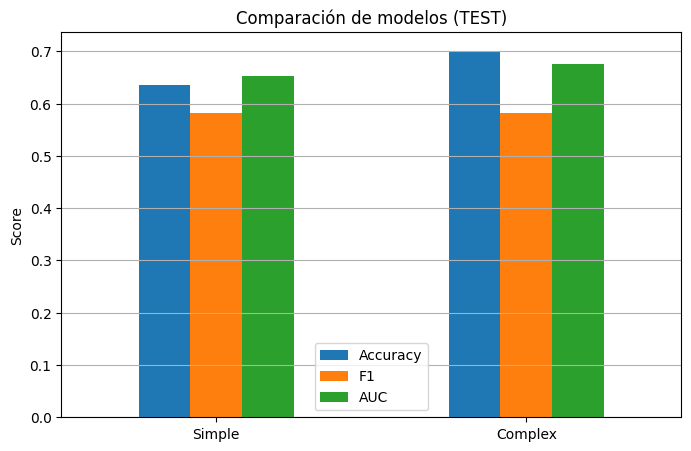

In [277]:
metrics_test = pd.DataFrame({
    'Simple': metrics_simple.loc['Test'],
    'Complex': metrics_complex.loc['Test']
}).T

metrics_test[['Accuracy', 'F1', 'AUC']].plot(
    kind='bar',
    figsize=(8,5)
)

plt.title('Comparación de modelos (TEST)')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

## **21. Optimizar**

In [278]:
param_grid = {
    'max_depth': [2, 3, 4, 5, 6],
    'min_samples_leaf': [5, 10, 20, 30],
    'max_features': ['sqrt', None]
}

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    scoring='f1',
    cv=5
)

grid.fit(X_train_sel, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [2, 3, 4, 5, 6],
                         'max_features': ['sqrt', None],
                         'min_samples_leaf': [5, 10, 20, 30]},
             scoring='f1')

In [279]:
best_tree = grid.best_estimator_

train_pred_best = best_tree.predict(X_train_sel)
test_pred_best = best_tree.predict(X_test_sel)

metrics_optimized = get_metrics(
    y_train,
    y_test,
    train_pred_best,
    test_pred_best
)

metrics_optimized

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.791531,0.711712,0.779870,0.683983,0.741784,0.817955
Test,0.701299,0.603448,0.686869,0.573770,0.636364,0.737374
Diferencia,0.090232,0.108263,0.093001,0.110212,0.105420,0.080581


## **22. Comparación entre el Original Simple y el Optimizado Simple** Si mejora

In [281]:
metrics_simple, metrics_optimized

(            Accuracy        F1       AUC  Precision    Recall  Specificity
 Train       0.723127  0.639831  0.719797   0.583012  0.708920     0.730673
 Test        0.636364  0.582090  0.652525   0.493671  0.709091     0.595960
 Diferencia  0.086763  0.057741  0.067271   0.089341 -0.000171     0.134714,
             Accuracy        F1       AUC  Precision    Recall  Specificity
 Train       0.791531  0.711712  0.779870   0.683983  0.741784     0.817955
 Test        0.701299  0.603448  0.686869   0.573770  0.636364     0.737374
 Diferencia  0.090232  0.108263  0.093001   0.110212  0.105420     0.080581)

## **23. Guardar y Cargar Modelo**

In [286]:

dump(metrics_optimized, "modelo.pkl")

['modelo.pkl']

In [287]:
metrics_optimized = load("modelo.pkl")